# Self-similar blowup for Burgers' Equation, via Gaussian Approximations

- Author: Kaiwen Zhang (kz2767@nyu.edu)
- Updates: 17-18 June 2025:
  - in fit_num, used faster implementation for constructing matrices
  - tried to fit kernel, but kernel seems singular, tried to reduce mse by making sigma small
  - tried to use indicator of 0 and L'Hopital to replace U(q)/q in definition of a, did not work
  - hard coded all inverse Fourier transforms and checked numericalk graphs
- Version: 16 June 2025, wrote code for approach 3

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import scipy.optimize as opt
import time
# jax and jit are not available with Sage
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, config

ModuleNotFoundError: No module named 'jax'

In [40]:
#display latex # makes things pretty but slow

In [41]:
#setup
x = var('x')
y = var('y')

# the following routines take a variable and produce an expression
# the argument q is the main variable for the expressions
# exact profile
def U(q):
    return (-(q/2) + ((1/27)+(q**2 / 4))**(1/2))**(1/3) - ((q/2) + ((1/27)+(q**2/4))**(1/2))**(1/3)

# symmetric Gaussian basis
def K(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2)) + exp(-(q+center)**2/(2 * sig**2))

# single Gaussian basis
def G(q, center, sig):
    return exp(-(q-center)**2/(2 * sig**2))

# a(x) and b(x) in linearized operator
def a(q):
    return 1 + U(q)/q + diff(U(q), q)
def b(q):
    return (3/2)*q + U(q)

# -------------------------------------------------------------------------
# linearized operator
# takes an expression and returns an expression
def T(g):
    # g is an expression and Tg = -ag - bg', derivative taken in 1st variable
    # for safety, only pass in single variable expressions
    q = g.variables()[0]
    return (-1) * a(q) * g - b(q) * diff(g, q)

In [42]:
# example - apply the operator to an easy function
f = exp(-x**2)
T(f)

(3*x - 2*(1/6*sqrt(1/3)*sqrt(27*x^2 + 4) + 1/2*x)^(1/3) + 2*(1/6*sqrt(1/3)*sqrt(27*x^2 + 4) - 1/2*x)^(1/3))*x*e^(-x^2) + 1/6*((9*sqrt(1/3)*x/sqrt(27*x^2 + 4) + 1)/(1/6*sqrt(1/3)*sqrt(27*x^2 + 4) + 1/2*x)^(2/3) - (9*sqrt(1/3)*x/sqrt(27*x^2 + 4) - 1)/(1/6*sqrt(1/3)*sqrt(27*x^2 + 4) - 1/2*x)^(2/3) + 6*((1/6*sqrt(1/3)*sqrt(27*x^2 + 4) + 1/2*x)^(1/3) - (1/6*sqrt(1/3)*sqrt(27*x^2 + 4) - 1/2*x)^(1/3))/x - 6)*e^(-x^2)

In [43]:
# the following tests will justify how the code is written below
# they are about how to evaluate expressions at variable x-y

z = var('z')
f = exp(abs(z))
try:
    print(f(x-y))
except TypeError:
    print("cannot directly plug in variable x-y to an expression whose variable is not x-y")

#need to substitute the variable z to x-y manually
print(f(z=x-y))


def fun(q):
    return exp(2*q)
# here it's okay to directly pass in x-y
print(fun(x-y))


def foo(q):
    return diff(exp(2*q),q)

try:
    print(foo(x-y))
except TypeError:
    print("cannot plug in variable x-y to generate an expression involving symbolic differentiation")

# need to generate the expression in a single variable and then substitute that variable by x-y
# this is consistent with the math, differentiate the single-variable function and evaluate at x-y
print(foo(z)(z=x-y))

cannot directly plug in variable x-y to an expression whose variable is not x-y
e^(abs(x - y))
e^(2*x - 2*y)
cannot plug in variable x-y to generate an expression involving symbolic differentiation
2*e^(2*x - 2*y)


In [44]:
# weights in expression <Tf, f> in H^3, in front of terms up to (f'')^2
# the (f''')^2 term is negative definite

# the following routines take a variable q and return an expression
# in front of f^2
def w_0(q):
    return -a(q) + diff(b(q),q)/2 + diff(a(q),q,2)/2 - diff(a(q),q,4)/2 + diff(a(q),q,6)/2

# in front of (f')^2
def w_1(q):
    return -a(q) - diff(b(q),q)/2 + 2*diff(a(q),q,2) + diff(b(q),q,3)/2 - 3*diff(a(q),q,4) - diff(b(q),q,5)/2

# in front of (f'')^2
def w_2(q):
    return -a(q) - diff(b(q),q)*(3/2) + diff(a(q),q,2)*(9/2) + diff(b(q),q,3)*(5/2)

$$\varphi_1^\vee (x) = \frac{\pi^3}{2} x\left(2\pi \lvert x\rvert +1\right) e^{-2\pi \lvert x\rvert}, \hspace{0.5em} \varphi_2^\vee (x) = \frac{\pi^3}{2}\left(4\pi^2 x^2 - 2\pi \lvert x\rvert -1\right) e^{-2\pi \lvert x\rvert}$$

In [45]:
# inverse fourier transforms - take a variable and return an expression
def phi_0(xi):
    return 1 / (1 + xi**2)**3

def phi_0_inv(q):
    return (pi/4) * exp(-2*pi*abs(q)) * (2*(pi**2)*(q**2) + 3*pi*abs(q) + 3/2)

def phi_1(xi):
    return -(2*pi*I*xi) / (1 + xi**2)**3

def phi_1_inv(q):
    return ((pi**3)/2) * q * (2*pi*abs(q) + 1) * exp(-2*pi*abs(q))

def phi_1_inv_ref(q):
    return -diff(phi_0_inv(q),q)

def phi_2(xi):
    return -(4*(pi**2)*(xi**2)) / (1 + xi**2)**3

def phi_2_inv(q):
    return ((pi**3)/2) * (4*(pi**2)*(q**2) - 2*pi*abs(q) - 1) * exp(-2*pi*abs(q))

def phi_2_inv_ref(q):
    z = var('z')
    return diff(phi_0_inv(z),z,2)(z=q)

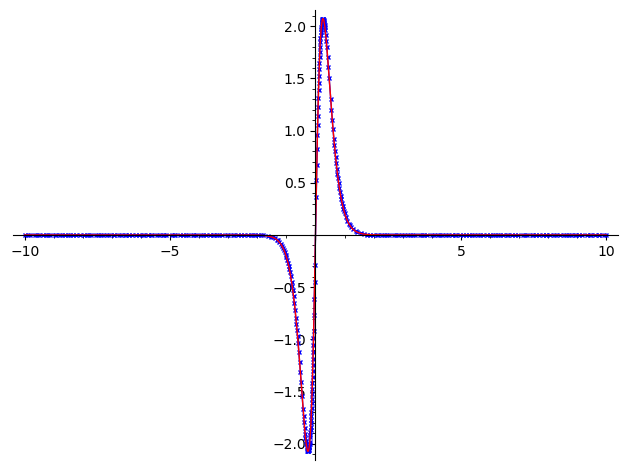

In [46]:
ln1 = plot(phi_1_inv(x), x, -10, 10, marker='x', markersize=3)
ln2 = plot(phi_1_inv_ref(x), x, -10, 10, color='red')
ln1 + ln2

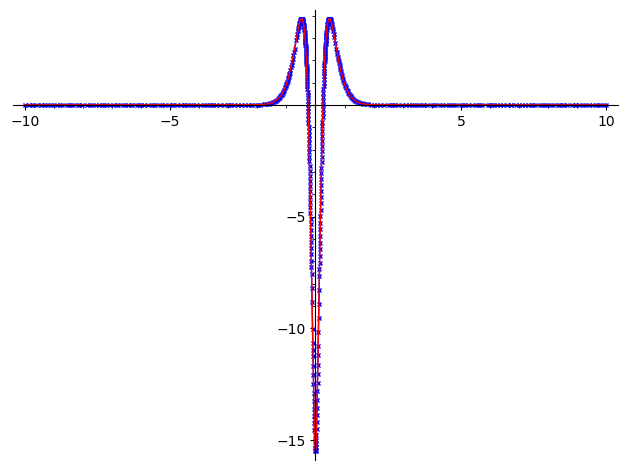

In [47]:
ln1 = plot(phi_2_inv(x), x, -10, 10, marker='x', markersize=3)
ln2 = plot(phi_2_inv_ref(x).simplify_full(), x, -10, 10, color='red')
ln1 + ln2

In [48]:
# the true kernel for the compact part of operator T
def Kernel(p,q):
    z = var('z') # dummy variable
    K_0 = phi_0_inv(p-q) * w_0(q)
    K_1 = diff(phi_1_inv(z),z)(z=p-q) * w_1(q) - phi_1_inv(z)(z=p-q) * diff(w_1(q),q)
    K_2 = (diff(phi_2_inv(z),z,2)(z=p-q) * w_2(q) - 2 * diff(phi_2_inv(z),z)(z=p-q) * diff(w_2(q),q) 
           + phi_2_inv(z)(z=p-q) * diff(w_2(q),q,2))
    return K_0 + K_1 + K_2

In [49]:
#phi_0_inv(x-y) * w_0(y)

## Fitting functions

There are three approaches of doing this:
- use the find_fit method in sagemath
  - if number of training points is high, this is very slow
- evaluate the function at data points, use matrix and vector fit in sagemath
- convert everything to numpy / numerics and use scipy to optimize

### Approach 1

- in general this is slow. 

Note: approach 2 works the same... matrix and vector fit is cumbersome to define. if we use the minimize method is sagemath, the code actually calls function in numpy.

In [50]:
A = matrix([[1,4],[2,3]])
var('s,x,m')
mode(x) = s * x + m
find_fit(A, mode)

[m == 5.0, s == -1.0]

In [51]:
# simple example of fitting a function - code works
var('t')
f(t) = exp(-abs(t))
pts = vector([-1+ j * (1/10) for j in range(101)])
data_pts = matrix([[pts[j], f(t=pts[j])] for j in range(len(pts))])
#print(data_pts)
params_li = var(','.join([f'x{j}' for j in range(101)]))
model_func(t) = sum([params_li[j] * G(t, pts[j], (1/4)) for j in range(101)])
#print(model_func)
result = find_fit(data_pts, model_func)
#print(result)

In [52]:
# routine that fits a function by Gaussian or symmetric Gaussian basis
def fit(func, basis_left=-100, basis_right=100, basis_num=201, basis_type='G', sigma=1/4,
        train_left=-100, train_right=100, train_num=401):
    
    """
    fits a single-variable function with a Gaussian or symmetric Gaussian basis
    Gaussian basis means a collection of Gaussians centered at a collection of points
    Inputs:
    - func: a symbolic expression with a single variable
    - basis_left: the left-most point that is used as the center of basis functions
    - basis_right: the right-most point as the center of basis functions
    - basis_num: number of basis, the centers of the Gaussian basis will be a uniform grid 
                 in [basis_left, basis_right] with basis_num points
    - basis_type: 'G' means a single Gaussian, 'K' means the symmetrized Gaussian
    - sigma: parameter for the Gaussian basis (variance of the Gaussian density)
    - train_left: the left most point used to evaluate func, we will fit the data of expression func at these points
    - train_right: right most point used to evaluate func
    - train_num: number of training points, these points will be taken from a uniform grid in [train_left, train_right]
    Outputs:
    - a list of equalities specifying the coefficients in front of the basis functions
    """
    
    if train_num < basis_num:
        raise TypeError("Too little training (data evaluation) points for too many basis functions")

    # extract the variable from func
    t = func.variables()[0]
    
    # true values of function to be fitted
    train_pts = vector([train_left + j*(train_right-train_left)/(train_num-1) for j in range(train_num)])
    true_vals = matrix([[train_pts[j], func.subs({t:train_pts[j]})] for j in range(train_num)])
    #print(true_vals)
    
    # setup the collection of basis functions
    params_li = var(','.join([f'x{j}' for j in range(basis_num)]))
    basis_pts = vector([basis_left + j*(basis_right-basis_left)/(basis_num-1) for j in range(basis_num)])
    model_fun = function('model_fun')
    if basis_type == 'G':
        model_fun(t) = sum([params_li[j] * G(t, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'K':
        model_fun(t) = sum([params_li[j] * K(t, basis_pts[j], sigma) for j in range(basis_num)])
    
    
    result = find_fit(true_vals, model_fun)
    if basis_type == 'G':
        approx_fun(t) = sum([result[j].rhs() * G(t, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'K':
        approx_fun(t) = sum([result[j].rhs() * K(t, basis_pts[j], sigma) for j in range(basis_num)])        
    
    return result, approx_fun
    

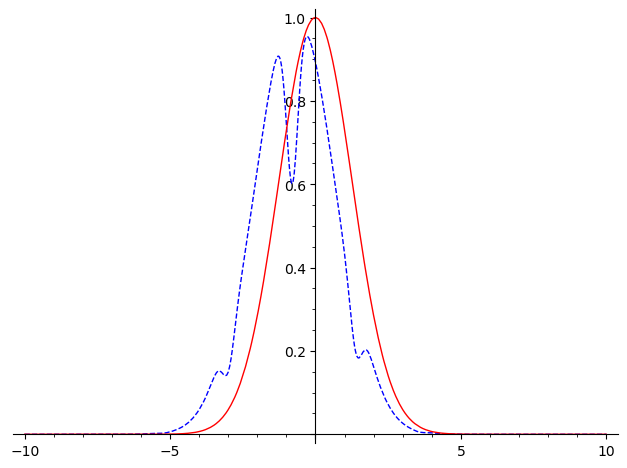

In [53]:
# the above function produces the same result as trial code
var('t')
f(t) = exp(-(1/10)*pi*t**2)
res, app = fit(f, basis_left=-10, basis_right=10, basis_num=101, basis_type='G', sigma=1/5,
               train_left=-10, train_right=10, train_num=2001)
line1 = plot(app, (t, -10, 10), linestyle='--',color='blue')
line2 = plot(f, (t, -10, 10), linestyle='-',color='red')
line1+line2

In [54]:
# this is too slow
# var('t')
# f(t) = cos(2*t) * exp((-1/10)* t**2) + (1/10) * cos(3*t)
# res, app = fit(f, basis_left=-15, basis_right=15, basis_num=501, basis_type='K', sigma=1/50,
#                train_left=-15, train_right=15, train_num=2501)
# line1 = plot(app, (t, -10, 10), linestyle='--',color='blue')
# line2 = plot(f, (t, -10, 10), linestyle='-',color='red')
# line1+line2

### Approach 3: convert everything to entirely numerical code and numpy least squares

- Updated 17 June 2025: faster implementation of setting up vector and matrix in fitting procedure
- Runs much faster

In [55]:
# APPROACH III
# first trial, works very well and fast
var('t')
f(t) = cos(2*t) * exp((-1/10)* t**2) + (1/10) * cos(3*t)
pts = vector([-1+ j * (1/20) for j in range(41)])
data_pts = vector([f(t=pts[j]) for j in range(len(pts))]).n()
var('p, q')
M_num = matrix([[K(p, q, (1/10)).subs({p:pts[i], q:pts[j]}) for i in range(41)] for j in range(41)]).n()

In [56]:
st = time.time()
result, residual, rk, s = np.linalg.lstsq(M_num, data_pts, rcond=None)
end = time.time()
print(result)
print("code ran for (seconds): ", end-st)

[ -1.80575143   5.57476398 -11.11218213  17.02162711 -22.47757742
  26.71052178 -29.53311874  31.05583043 -31.37318758  30.98601932
 -29.85941267  28.61666111 -26.96816857  25.59971445 -23.98795435
  22.88479158 -21.59175776  20.92835436 -20.08010033  19.91888581
 -19.56694944  19.91888581 -20.08010033  20.92835436 -21.59175776
  22.88479158 -23.98795435  25.59971445 -26.96816857  28.61666111
 -29.85941268  30.98601933 -31.3731876   31.05583033 -29.5331185
  26.71052158 -22.47757765  17.02162751 -11.11218231   5.57476398
  -1.80575137]
code ran for (seconds):  0.002662181854248047


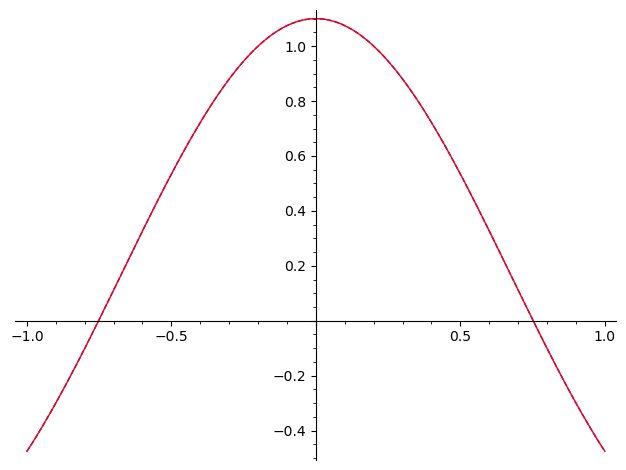

In [57]:
approx_fun(t) = sum([result[j] * K(t, pts[j], (1/10)) for j in range(41)])
line1 = plot(approx_fun, (t, -1, 1), linestyle='--',color='blue')
line2 = plot(f, (t, -1, 1), linestyle='-',color='red')
line1+line2

In [58]:
# write this in a function
def fit_num(func, basis_left=-10, basis_right=10, basis_num=201, basis_type='G', sigma=1/10,
            train_left=-10, train_right=10, train_num=401):
    
    """
    fits a single-variable function with a Gaussian or symmetric Gaussian basis
    Gaussian basis means a collection of Gaussians centered at a collection of points
    Inputs:
    - func: a symbolic expression with a single variable
    - basis_left: the left-most point that is used as the center of basis functions
    - basis_right: the right-most point as the center of basis functions
    - basis_num: number of basis, the centers of the Gaussian basis will be a uniform grid 
                 in [basis_left, basis_right] with basis_num points
    - basis_type: 'G' means a single Gaussian, 'K' means the symmetrized Gaussian
    - sigma: parameter for the Gaussian basis (variance of the Gaussian density)
    - train_left: the left most point used to evaluate func, we will fit the data of expression func at these points
    - train_right: right most point used to evaluate func
    - train_num: number of training points, these points will be taken from a uniform grid in [train_left, train_right]
    Outputs:
    - a list of numerical numbers specifying the coefficients in front of the basis functions
    - the approximate function as a symbolic expression, but the coefficients are numerical
    """
    
    if train_num < basis_num:
        raise TypeError("Too little training (data evaluation) points for too many basis functions")

    # extract the variable from func
    t = func.variables()[0]
    
    print("Setting up matrix and vector...")
    st = time.time()
    # true values of function to be fitted
    train_pts = vector([train_left + j*(train_right-train_left)/(train_num-1) for j in range(train_num)])
    # this is a faster implementation... thanks chatgpt
    f_fast = fast_callable(func, vars=[t], domain=RR)
    true_vals = vector(RR, [f_fast(x) for x in train_pts])
    #true_vals = vector([func.subs({t:train_pts[j]}) for j in range(train_num)]).n()
    #print(true_vals)
    
    # setup the collection of basis functions
    var('p, q, r')
    basis_pts = vector([basis_left + j*(basis_right-basis_left)/(basis_num-1) for j in range(basis_num)])
    
    if basis_type == 'G':
        #the faster implementation is the latter one... thanks chatgpt
        #M_norm = matrix([[G(p, q, r).subs({p:train_pts[i], q:basis_pts[j], r:sigma}) for j in range(basis_num)] 
        #                   for i in range(train_num)]).n()
        fG = fast_callable(G(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, 
                lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
        
    elif basis_type == 'K':
        #M_norm = matrix([[K(p, q, r).subs({p:train_pts[i], q:basis_pts[j], r:sigma}) for j in range(basis_num)]
        #                 for i in range(train_num)]).n()
        fG = fast_callable(K(p, q, r), vars=[p, q, r], domain=RR)
        M_norm = matrix(RR, train_num, basis_num, 
                lambda i, j: fG(train_pts[i], basis_pts[j], sigma))
    end = time.time()
    print(f"Matrix and vector set up in (seconds):    {round(end-st, 4)}")
    print("Setup complete, fitting function using numpy least squares...")
    
    # use numpy least squares to fit
    st = time.time()
    result, residual, rk, sth = np.linalg.lstsq(M_norm, true_vals, rcond=None)
    end = time.time()
    mse = np.mean((np.dot(M_norm, result) - true_vals)**2)
    print(f"Fitting complete, code ran for (seconds): {round(end-st, 4)}")
    print(f"Mean squared error:                       {mse}")
    
    # calculate the approximate function
    if basis_type == 'G':
        approx_fun = sum([result[j] * G(t, basis_pts[j], sigma) for j in range(basis_num)])
    elif basis_type == 'K':
        approx_fun = sum([result[j] * K(t, basis_pts[j], sigma) for j in range(basis_num)])        
    
    return result, approx_fun, mse
    

Setting up matrix and vector...
Matrix and vector set up in (seconds):    0.0642
Setup complete, fitting function using numpy least squares...
Fitting complete, code ran for (seconds): 0.0261
Mean squared error:                       8.874015200737556e-08


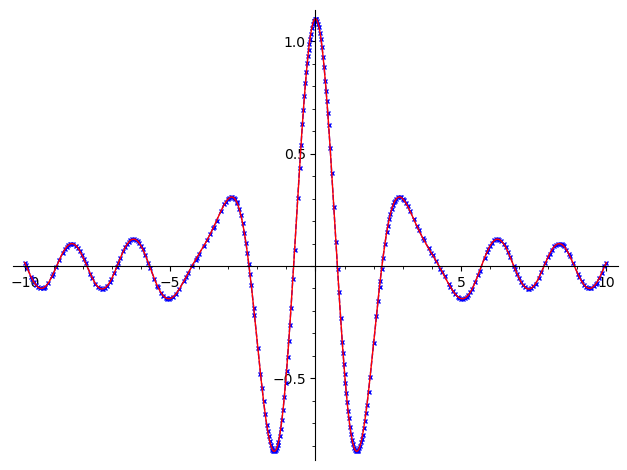

In [59]:
# this works much much better!!!
var('t')
#f(t) = exp(-(1/10)*pi*t**2)
f(t) = cos(2*t) * exp((-1/10)* t**2) + (1/10) * cos(3*t)
res, app, err = fit_num(f, basis_left=-10, basis_right=10, basis_num=101, basis_type='K', sigma=1/5,
                        train_left=-10, train_right=10, train_num=201)
line1 = plot(app, (t, -10, 10), marker='x', markersize=3, linestyle='--',color='blue')
line2 = plot(f, (t, -10, 10), linestyle='-',color='red')
line1+line2

Setting up matrix and vector...
Matrix and vector set up in (seconds):    0.6188
Setup complete, fitting function using numpy least squares...
Fitting complete, code ran for (seconds): 0.3427
Mean squared error:                       1.8537973876862646e-15


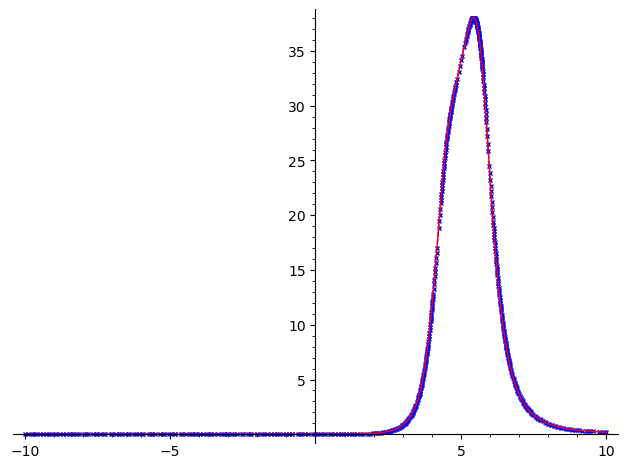

In [61]:
# we can fit using Gaussians instead of symmetrized Gaussians
var('t')
#f(t) = exp(-(1/10)*pi*t**2)
#f(t) = cos(2*t) * exp((-1/10)* t**2) + (1/10) * cos(3*t)
# an asymmetric function
#f(t) = exp(-(1/10)*pi*(t-4)**2)
f(t) = (t**2 + 2*t -1) / (1+(t-5)**4)
res, app, err = fit_num(f, basis_left=-10, basis_right=10, basis_num=250, basis_type='G', sigma=1/5,
                        train_left=-10, train_right=10, train_num=1000)
line1 = plot(app, (t, -10, 10), marker='x', markersize=3, linestyle='--',color='blue')
line2 = plot(f, (t, -10, 10), linestyle='-',color='red')
line1+line2

## Approximate Operator

We have an integral operator of form
$$Tf(x) = \int K(x, y) f(y)dy$$
And we approximate by a Riemann sum
$$Tf(x) \approx \sum_{i\in I_1} K(x, y_i) f(y_i) \Delta_y$$
After this we approximate each of the kernel $K(x,y_i)$ as a function in $x$.
So the approximate operator is
$$Tf \approx \sum_{i\in I_1} \sum_{j \in I_2} C_{ij}K_{ij}(x) f(y_i) \Delta_y$$

Moreover, for functions in $H^3$, the $\delta$ functional can be represented as inner product with an element in $H^3$. So in effect
$$Tf \approx \sum_{i\in I_1}\sum_{j\in I_2} C_{ij}K_{ij}(x) \int f(y) \eta_{y_i}(y) dy \Delta_y$$

In [62]:
quad_pts = [-10+ j * (1/2) for j in range(41)]
delta_y = 1/2
x = var('x')
y = var('y')

In [63]:
# let's try to fit the kernel
Ker = Kernel(x,y)
kernel_at_y0 = Ker.subs({y:1/10}).simplify_full()
kernel_at_y0.variables()

(x,)

In [64]:
# this causes trouble if we don't use simplify_full()
D[0](conjugate)(-101/10).simplify_full().n()

1.00000000000000

Setting up matrix and vector...
Matrix and vector set up in (seconds):    12.0968
Setup complete, fitting function using numpy least squares...
Fitting complete, code ran for (seconds): 6.5797
Mean squared error:                       36576.79245507387


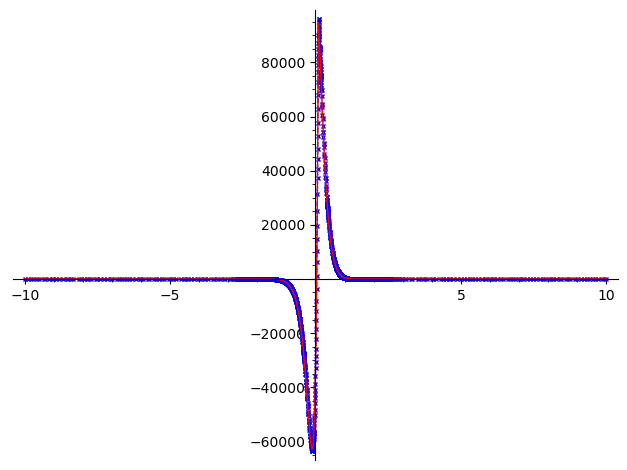

In [ ]:
res, app, err = fit_num(kernel_at_y0, basis_left=-10, basis_right=10, basis_num=4000, basis_type='G', sigma=1/100,
                        train_left=-10, train_right=10, train_num=5000)
line1 = plot(app, (t, -10, 10), marker='x', markersize=3, linestyle='--',color='blue')
line2 = plot(kernel_at_y0, (t, -10, 10), linestyle='-',color='red')
line1+line2

In [27]:
# approx_f_li = []
# for pt in quad_pts:
#     kernel_at_pt(x) = Kernel(x, y).subs({y:pt})
#     res, app, err = fit_num(kernel_at_y0, basis_left=-10, basis_right=10, basis_num=100, basis_type='K', sigma=1/5,
#                             train_left=-10, train_right=10, train_num=201)
#     eta_at_pt = 0
    

# sum over all quadrature points

## Interval arithmetic